In [1]:
!sudo pip install -U nltk
!pip install jsonlines

    100% |████████████████████████████████| 1.4MB 918kB/s eta 0:00:01
Requirement already up-to-date: singledispatch in /usr/lib/python2.7/dist-packages (from nltk)
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: six 1.10.0
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
import requests
import io
import numpy as np
from zipfile import ZipFile

In [4]:
SNLI_PATH = 'snli_1.0'
#STS_PATH = 'sts2016-english-with-gs-v1.0'

if not os.path.exists(SNLI_PATH):
    url_address = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
    request = requests.get(url_address)
    zfile = ZipFile(io.BytesIO(request.content))
    zfile.extractall()
    zfile.close()

#if not os.path.exists(STS_PATH):
#    url_address = "http://alt.qcri.org/semeval2016/task1/data/uploads/sts2016-english-with-gs-v1.0.zip"
#    request = requests.get(url_address)
#    zfile = ZipFile(io.BytesIO(request.content))
#    zfile.extractall()

In [5]:
import boto3 
import sys, os
import jsonlines
import json
from collections import Counter
from itertools import chain, islice
from nltk.tokenize import TreebankWordTokenizer

In [6]:
# constants

BOS_SYMBOL = "<s>"
EOS_SYMBOL = "</s>"
UNK_SYMBOL = "<unk>"
PAD_SYMBOL = "<pad>"
PAD_ID = 0
TOKEN_SEPARATOR = " "
VOCAB_SYMBOLS = [PAD_SYMBOL, UNK_SYMBOL, BOS_SYMBOL, EOS_SYMBOL]

 
LABEL_DICT = {'entailment':0, 'neutral':1, 'contradiction':2}

In [7]:
#### Utility functions

def read_jsonline(fname):
    """
    Reads jsonline files and returns iterator
    """
    with jsonlines.open(fname) as reader:
        for line in reader:
            yield line

def sentence_to_integers(sentence, tokenizer, word_dict):
    """
    Converts a string of tokens to a list of integers
    TODO: Better handling of the case 
          where token is not in word_dict
    """
    return [word_dict[token] for token in get_tokens(sentence, tokenizer)
           if token in word_dict]


def get_tokens(line, tokenizer):
    """
    Yields tokens from input string.

    :param line: Input string.
    :return: Iterator over tokens.
    """
    for token in tokenizer.tokenize(line):
        if len(token) > 0:
            yield token

            
def get_tokens_from_snli(input_dict, tokenizer):
    iter_list = list()
    for sentence_key in ['sentence1', 'sentence2']:
        sentence = input_dict[sentence_key]
        iter_list.append(get_tokens(sentence, tokenizer))
    return chain(iter_list[0], iter_list[1])


def get_tokens_from_sts(input_sentence_pair, tokenizer):
    iter_list = list()
    for s in input_sentence_pair:
        iter_list.append(get_tokens(s, tokenizer))
    return chain(iter_list[0], iter_list[1])


def resolve_snli_label(raw_label):
    """
    Converts raw label to integer
    """
    return LABEL_DICT[raw_label]

In [8]:
def build_vocab(data_iter, dataname='snli', num_words=50000, min_count=1, use_reserved_symbols=True, sort=True):
    """
    Creates a vocabulary mapping from words to ids. Increasing integer ids are assigned by word frequency,
    using lexical sorting as a tie breaker. The only exception to this are special symbols such as the padding symbol
    (PAD).

    :param data_iter: Sequence of sentences containing whitespace delimited tokens.
    :param num_words: Maximum number of words in the vocabulary.
    :param min_count: Minimum occurrences of words to be included in the vocabulary.
    :return: word-to-id mapping.
    """
    vocab_symbols_set = set(VOCAB_SYMBOLS)
    tokenizer = TreebankWordTokenizer()
    if dataname == 'snli':
        raw_vocab = Counter(token for line in data_iter for token in get_tokens_from_snli(line, tokenizer)
                        if token not in vocab_symbols_set)
    elif dataname == 'sts':
        raw_vocab = Counter(token for line in data_iter for token in get_tokens_from_sts(line, tokenizer) 
                            if token not in vocab_symbols_set)
    else:
        raise NameError(f'Data name {dataname} is not recognized!')
        
    print("Initial vocabulary: {} types".format(len(raw_vocab)))

    # For words with the same count, they will be ordered reverse alphabetically.
    # Not an issue since we only care for consistency
    pruned_vocab = sorted(((c, w) for w, c in raw_vocab.items() if c >= min_count), reverse=True)
    print("Pruned vocabulary: {} types (min frequency {})".format(len(pruned_vocab), min_count))
    
    # truncate the vocabulary to fit size num_words (only includes the most frequent ones)
    vocab = islice((w for c, w in pruned_vocab), num_words)

    if sort:
        # sort the vocabulary alphabetically
        vocab = sorted(vocab)
    if use_reserved_symbols:
        vocab = chain(VOCAB_SYMBOLS, vocab)
    
    word_to_id = {word: idx for idx, word in enumerate(vocab)}

    print("Final vocabulary: {} types".format(len(word_to_id)))

    if use_reserved_symbols:
        # Important: pad symbol becomes index 0
        assert word_to_id[PAD_SYMBOL] == PAD_ID
    return word_to_id

In [9]:
def convert_snli_to_integers(data_iter, word_to_id, dirname=SNLI_PATH, fname_suffix=""):
    """
    Go through snli jsonline file line by line and convert sentences to list of integers
    - convert entailments to labels
    """ 
    fname = 'snli-integer-' + fname_suffix + '.jsonl'
    path = os.path.join(dirname, fname)
    tokenizer = TreebankWordTokenizer()
    count = 0
    max_seq_length = 0
    with jsonlines.open(path, mode='w') as writer:
        for in_dict in data_iter:
            #in_dict = json.loads(line)
            out_dict = dict()
            rlabel = in_dict['gold_label']
            if rlabel in LABEL_DICT:
                rsentence1 = in_dict['sentence1']
                rsentence2 = in_dict['sentence2']
                for idx, sentence in enumerate([rsentence1, rsentence2]):
                    #print(count, sentence)
                    s = sentence_to_integers(sentence, tokenizer, word_to_id)
                    out_dict[f'in{idx}'] = s
                    count += 1
                    max_seq_length = max(len(s), max_seq_length)
                out_dict['label'] = resolve_snli_label(rlabel)
                writer.write(out_dict)
            else:
                count += 1
    print(f"There are in total {count} invalid labels")
    print(f"The max length of converted sequence is {max_seq_length}")

In [10]:
def make_snli_full_vocab(dirname=SNLI_PATH, force=True):
    vocab_path = os.path.join(dirname, 'snli-vocab.json')
    if not os.path.exists(vocab_path) or force:
        data_iter_list = list()
        for fname_suffix in ["train", "test", "dev"]:
            fname = "snli_1.0_" + fname_suffix + ".jsonl"
            data_iter_list.append(read_jsonline(os.path.join(dirname, fname)))
        data_iter = chain(data_iter_list[0], data_iter_list[1], data_iter_list[2])
        with open(vocab_path, "w") as write_file:
            word_to_id = build_vocab(data_iter, num_words=50000, min_count=1, use_reserved_symbols=False, sort=True)
            json.dump(word_to_id, write_file)

make_snli_full_vocab(force=False)

In [11]:
def make_snli_data(dirname=SNLI_PATH, vocab_file='snli-vocab.json', outfile_suffix="", force=True):
    for fname_suffix in ["train", "test", "validation"]:
        outpath = os.path.join(dirname, f'snli-integer-{fname_suffix}-{outfile_suffix}.jsonl')
        if not os.path.exists(outpath) or force:
            if fname_suffix=='validation':
                inpath = os.path.join(dirname, f'snli_1.0_dev.jsonl')
            else:
                inpath = os.path.join(dirname, f'snli_1.0_{fname_suffix}.jsonl')
            data_iter = read_jsonline(inpath)
            vocab_path = os.path.join(dirname, vocab_file)
            with open(vocab_path, "r") as f:
                word_to_id = json.load(f)   
            convert_snli_to_integers(data_iter, word_to_id, dirname=dirname, 
                                     fname_suffix=f'{fname_suffix}-{outfile_suffix}')

            
make_snli_data(force=False)

In [12]:
def print_vocab_size(vocab_path):
    with open(vocab_path) as f:
        word_to_id = json.load(f)
        print(f"There are {len(word_to_id.keys())} words in vocabulary {vocab_path}")
    

vocab_path = os.path.join(SNLI_PATH, 'snli-vocab.json')
print_vocab_size(vocab_path)

There are 43533 words in vocabulary snli_1.0/snli-vocab.json


In [20]:
## Define hyperparameters and define S3 input path
DEFAULT_HP = {
  "enc_dim": 4096,
  "mlp_dim": 512,
  "mlp_activation": "linear",
  "mlp_layers": 2,
  "output_layer" : "softmax",

  "optimizer" : "adam",
  "learning_rate" : 0.0004,
  "mini_batch_size": 32,
  "epochs" : 20,
  "bucket_width": 0,

  "early_stopping_tolerance" : 0.01,
  "early_stopping_patience" : 3,

  "dropout": 0,
  "weight_decay": 0,

  "enc0_max_seq_len": 82,
  "enc1_max_seq_len": 82,

  "enc0_network": "hcnn",
  "enc1_network": "enc0",

  "enc0_token_embedding_dim": 300,
  "enc0_layers": "auto",
  "enc0_cnn_filter_width": 3,

  "enc1_token_embedding_dim": 300,
  "enc1_layers": "auto",
  "enc1_cnn_filter_width": 3,

  "enc0_vocab_file" : "",
  "enc1_vocab_file" : "",

  "enc0_vocab_size" : 43533,
  "enc1_vocab_size" : 43533,

  "num_classes": 3,

  "_num_gpus" : "auto",
  "_num_kv_servers" : "auto",
  "_kvstore" : "device"
}

In [21]:
## Input data bucket and prefix

bucket = 'aws-ml-chicago-team-bravesouls' # Customize your bucket
prefix = 'object2vec/input/' 
input_path = os.path.join('s3://', bucket, prefix)
print(f"Data path for training is {input_path}")
## Output path
output_prefix = 'object2vec/output/'
output_bucket = bucket
output_path = os.path.join('s3://', output_bucket, output_prefix)
print(f"Trained model will be saved at {output_path}")

Data path for training is s3://aws-ml-chicago-team-bravesouls/object2vec/input/
Trained model will be saved at s3://aws-ml-chicago-team-bravesouls/object2vec/output/


In [22]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()


role = get_execution_role()
print(role)

## Get docker image of ObjectToVec algorithm
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'object2vec')

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824


In [27]:
import sagemaker
from sagemaker.session import s3_input


def set_training_environment(bucket, prefix, base_hyperparameters=DEFAULT_HP,
                             is_quick_run=True, is_pretrain=False, use_all_vocab=False):
    
    input_channels = {}
    s3_client = boto3.client('s3')
    for split in ['train', 'validation']:
        if is_pretrain:
            fname_in = f'all_vocab_datasets/snli-integer-{split}-pretrain.jsonl'
            fname_out = f'{split}/snli-integer-{split}-pretrain.jsonl'
        else:
            fname_in = os.path.join(SNLI_PATH, f'snli-integer-{split}-.jsonl')
            fname_out = f'{split}/snli-integer-{split}.jsonl'
        
        s3_client.upload_file(fname_in, bucket, os.path.join(prefix, fname_out))
        input_channels[split] = s3_input(input_path + fname_out, 
                                 distribution='ShardedByS3Key', 
                                 content_type='application/jsonlines')
    
        print('Uploaded {} data to {}'.format(split, input_path + fname_out))
    
    hyperparameters = base_hyperparameters.copy()
    
    if use_all_vocab:
        hyperparameters['enc0_vocab_file'] = 'all_vocab.json'
        hyperparameters['enc1_vocab_file'] = 'all_vocab.json'
        hyperparameters['enc0_vocab_size'] = 43662
        hyperparameters['enc1_vocab_size'] = 43662

    if is_pretrain:
        ## set up auxliary channel
        aux_path = os.path.join(prefix, "auxiliary")
        # upload auxiliary files
        assert os.path.exists("GloVe/glove.840B-trim.txt"), "Pretrained embedding does not exist!"
        s3_client.upload_file("GloVe/glove.840B-trim.txt", bucket, os.path.join(aux_path, 'glove.840B-trim.txt'))
        if use_all_vocab:
            s3_client.upload_file('all_vocab_datasets/all_vocab.json', 
                                  bucket, os.path.join(aux_path, 'all_vocab.json'))
        else:
            s3_client.upload_file("snli_1.0/snli-vocab.json", 
                                  bucket, os.path.join(aux_path, "snli-vocab.json"))

        input_channels['auxiliary'] = s3_input('s3://' + bucket + '/' + aux_path, 
                                     distribution='FullyReplicated', content_type='application/json')
        
        print('Uploaded auxiliary data for initializing with pretrain-embedding to {}'.format(aux_path))
        
        # add pretrained_embedding_file name to hyperparameters
        for idx in [0, 1]:
            hyperparameters[f'enc{idx}_pretrained_embedding_file'] = 'glove.840B-trim.txt'

    if is_quick_run:
        hyperparameters['mini_batch_size'] = 8192
        hyperparameters['enc_dim'] = 16
        hyperparameters['epochs'] = 20
    else:
        hyperparameters['mini_batch_size'] = 256
        hyperparameters['enc_dim'] = 8192
        hyperparameters['epochs'] = 20
    return hyperparameters, input_channels

In [28]:
## get estimator
regressor = sagemaker.estimator.Estimator(container,
                                          role, 
                                          train_instance_count=1, 
                                          train_instance_type='ml.p2.xlarge',
                                          output_path=output_path,
                                          sagemaker_session=sess)


## set up training environment
"""
- To get good training result, set is_quick_run to False 
- To test-run the algorithm quickly, set is_quick_run to True
"""
hyperparameters, input_channels = set_training_environment(bucket, prefix, 
                                                           is_quick_run=True, 
                                                           is_pretrain=False, use_all_vocab=False)

regressor.set_hyperparameters(**hyperparameters)
regressor.hyperparameters()

Uploaded train data to s3://aws-ml-chicago-team-bravesouls/object2vec/input/train/snli-integer-train.jsonl
Uploaded validation data to s3://aws-ml-chicago-team-bravesouls/object2vec/input/validation/snli-integer-validation.jsonl


{'enc_dim': 16,
 'mlp_dim': 512,
 'mlp_activation': 'linear',
 'mlp_layers': 2,
 'output_layer': 'softmax',
 'optimizer': 'adam',
 'learning_rate': 0.0004,
 'mini_batch_size': 8192,
 'epochs': 20,
 'bucket_width': 0,
 'early_stopping_tolerance': 0.01,
 'early_stopping_patience': 3,
 'dropout': 0,
 'weight_decay': 0,
 'enc0_max_seq_len': 82,
 'enc1_max_seq_len': 82,
 'enc0_network': 'hcnn',
 'enc1_network': 'enc0',
 'enc0_token_embedding_dim': 300,
 'enc0_layers': 'auto',
 'enc0_cnn_filter_width': 3,
 'enc1_token_embedding_dim': 300,
 'enc1_layers': 'auto',
 'enc1_cnn_filter_width': 3,
 'enc0_vocab_file': '',
 'enc1_vocab_file': '',
 'enc0_vocab_size': 43533,
 'enc1_vocab_size': 43533,
 'num_classes': 3,
 '_num_gpus': 'auto',
 '_num_kv_servers': 'auto',
 '_kvstore': 'device'}

In [29]:
regressor.fit(input_channels)

INFO:sagemaker:Creating training-job with name: object2vec-2019-01-10-05-58-53-308


2019-01-10 05:58:53 Starting - Starting the training job...
2019-01-10 05:58:55 Starting - Launching requested ML instances......
2019-01-10 06:00:02 Starting - Preparing the instances for training......
2019-01-10 06:01:21 Downloading - Downloading input data...
2019-01-10 06:01:35 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[01/10/2019 06:02:05 INFO 140672066094912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 20, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'enc0_token_embedding_dim': 300, u'enc1_network': u'enc0', u'learning_rate': 0.0004, u'enc1_cnn_filter_width': 3, u'negative_sampling_rate': 0, u'enc0_network': u'hcnn', u'enc1_layers': u'auto', u'early_st

[01/10/2019 06:03:48 INFO 140672066094912] **************
[01/10/2019 06:03:48 INFO 140672066094912] Completed Epoch: 0, time taken: 0:01:07.389699
[01/10/2019 06:03:48 INFO 140672066094912] Epoch 0 Training metrics:   perplexity: 2.585 cross_entropy: 0.950 accuracy: 0.550 
[01/10/2019 06:03:48 INFO 140672066094912] #quality_metric: host=algo-1, epoch=0, train cross_entropy <loss>=0.949708053294
[01/10/2019 06:03:48 INFO 140672066094912] #quality_metric: host=algo-1, epoch=0, train accuracy <score>=0.54950130687
[01/10/2019 06:03:48 INFO 140672066094912] Epoch 0 Validation metrics: perplexity: 2.244 cross_entropy: 0.808 accuracy: 0.647 
[01/10/2019 06:03:48 INFO 140672066094912] #quality_metric: host=algo-1, epoch=0, validation cross_entropy <loss>=0.808074295521
[01/10/2019 06:03:48 INFO 140672066094912] #quality_metric: host=algo-1, epoch=0, validation accuracy <score>=0.646545410156
[01/10/2019 06:03:48 INFO 140672066094912] **************
#metrics {"Metrics": {"epochs": {"count": 1

[01/10/2019 06:08:23 INFO 140672066094912] **************
[01/10/2019 06:08:23 INFO 140672066094912] Completed Epoch: 4, time taken: 0:01:07.491277
[01/10/2019 06:08:23 INFO 140672066094912] Epoch 4 Training metrics:   perplexity: 1.972 cross_entropy: 0.679 accuracy: 0.712 
[01/10/2019 06:08:23 INFO 140672066094912] #quality_metric: host=algo-1, epoch=4, train cross_entropy <loss>=0.678942636532
[01/10/2019 06:08:23 INFO 140672066094912] #quality_metric: host=algo-1, epoch=4, train accuracy <score>=0.712007410386
[01/10/2019 06:08:24 INFO 140672066094912] Epoch 4 Validation metrics: perplexity: 2.174 cross_entropy: 0.777 accuracy: 0.670 
[01/10/2019 06:08:24 INFO 140672066094912] #quality_metric: host=algo-1, epoch=4, validation cross_entropy <loss>=0.776619881392
[01/10/2019 06:08:24 INFO 140672066094912] #quality_metric: host=algo-1, epoch=4, validation accuracy <score>=0.669799804688
[01/10/2019 06:08:24 INFO 140672066094912] **************
[01/10/2019 06:08:24 INFO 140672066094912]


2019-01-10 06:10:43 Uploading - Uploading generated training model
2019-01-10 06:11:25 Completed - Training job completed
Billable seconds: 604


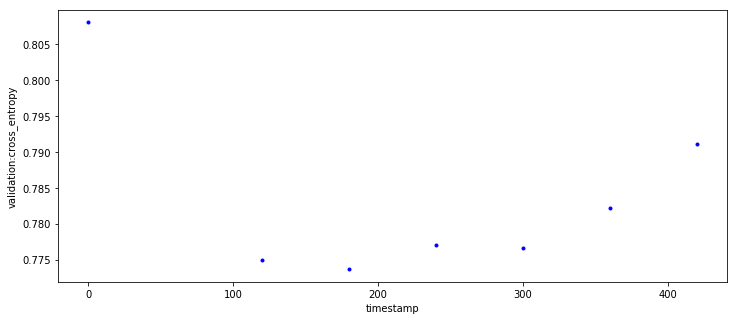

In [30]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = regressor.latest_training_job.job_name
metric_name = 'validation:cross_entropy'

metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

In [31]:
from sagemaker.predictor import json_serializer, json_deserializer

# deploy model and create endpoint and with customer-defined endpoint_name
predictor1 = regressor.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object2vec-2019-01-10-06-12-08-834
INFO:sagemaker:Creating endpoint with name object2vec-2019-01-10-05-58-53-308


--------------------------------------------------------------------------!

In [32]:
# define encode-decode format for inference data
predictor1.content_type = 'application/json'
predictor1.serializer = json_serializer
predictor1.deserializer = json_deserializer

In [33]:
def calc_prediction_accuracy(predictions, labels):
    loss = 0
    for idx, s_and_l in enumerate(zip(predictions['predictions'], labels)):
        score, label = s_and_l
        plabel = np.argmax(score['scores'])
        loss += int(plabel != label['label'])
    return 1 - loss / len(labels)

In [34]:
import math
import sagemaker
from sagemaker.predictor import json_serializer, json_deserializer

# load SNLI test data
snli_test_path = os.path.join(SNLI_PATH, 'snli-integer-test-.jsonl')
test_data_content = list()
test_label = list()

for line in read_jsonline(snli_test_path):
    test_data_content.append({'in0':line['in0'], 'in1':line['in1']})
    test_label.append({'label': line['label']})

print("Evaluating test results on SNLI without pre-trained embedding...")


batch_size = 100
n_test = len(test_label)
n_batches = math.ceil(n_test / float(batch_size))
start = 0
agg_acc = 0
for idx in range(n_batches):
    if idx % 10 == 0:
        print(f"Evaluating the {idx+1}-th batch")
    end = (start + batch_size) if (start + batch_size) <= n_test else n_test
    payload = {'instances': test_data_content[start:end]}
    acc = calc_prediction_accuracy(predictor1.predict(payload), test_label[start:end])
    agg_acc += acc * (end-start+1)
    start = end
print(f"The test accuracy is {agg_acc/n_test}")

Evaluating test results on SNLI without pre-trained embedding...
Evaluating the 1-th batch
Evaluating the 11-th batch
Evaluating the 21-th batch
Evaluating the 31-th batch
Evaluating the 41-th batch
Evaluating the 51-th batch
Evaluating the 61-th batch
Evaluating the 71-th batch
Evaluating the 81-th batch
Evaluating the 91-th batch
The test accuracy is 0.6618359799131378
